# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

Business Goal:

The used car dealership wants to understand what makes some used cars more valuable than others, so they can make better inventory and pricing decisions.

Task:

We aim to build a predictive regression model that estimates a car’s resale price based on its features (e.g., make, model, year, mileage, condition). This model will help identify the attributes most strongly correlated with higher or lower vehicle prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### **Collect Initial Data:**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data/vehicles.csv')
# Initial Data Collection Report
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 426880 rows and 18 columns.


### **Describe Data:**

In [4]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
# Data types
print("\nColumn Data Types:\n")
print(df.dtypes)


Column Data Types:

id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object


In [6]:
print("\nUnique Values Per Column:\n")
print(df.nunique().sort_values(ascending=False))


Unique Values Per Column:

id              426880
VIN             118246
odometer        104870
model            29649
price            15655
region             404
year               114
state               51
manufacturer        42
type                13
paint_color         12
cylinders            8
title_status         6
condition            6
fuel                 5
size                 4
drive                3
transmission         3
dtype: int64


In [7]:
print("\nDataset Shape:\n")
print(df.shape)


Dataset Shape:

(426880, 18)


### **Explore Data:**

In [8]:
# Summary for numerical features
df.describe()

# Summary for categorical features (top 10)
df.select_dtypes(include='object').describe().T.head(10)


,count,unique,top,freq
region,426880,404,columbus,3608
manufacturer,409234,42,ford,70985
model,421603,29649,f-150,8009
condition,252776,6,good,121456
cylinders,249202,8,6 cylinders,94169
fuel,423867,5,gas,356209
title_status,418638,6,clean,405117
transmission,424324,3,automatic,336524
VIN,265838,118246,1FMJU1JT1HEA52352,261
drive,296313,3,4wd,131904


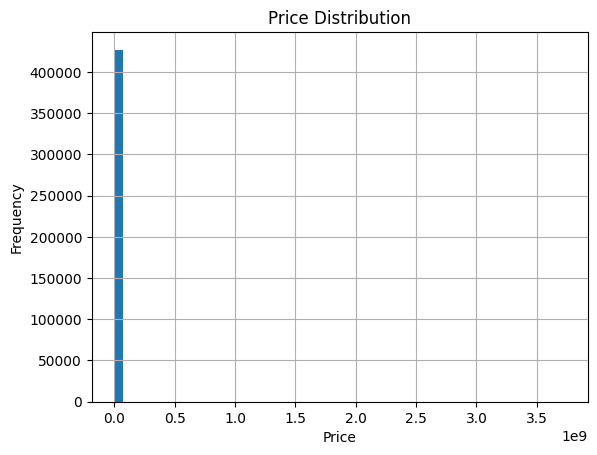

In [9]:
# Histograms of key numeric fields
df['price'].hist(bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Calculate stats
min_price = df['price'].min()
max_price = df['price'].max()
median_price = df['price'].median()
mean_price = round(df['price'].mean())  # Rounded since price is in whole dollars

# Frequency lookup
min_freq = df['price'].value_counts().get(min_price, 0)
max_freq = df['price'].value_counts().get(max_price, 0)
median_freq = df['price'].value_counts().get(median_price, 0)
mean_freq = df['price'].value_counts().get(mean_price, 0)

# Display results
print(f"Minimum Price: ${min_price:,} (Frequency: {min_freq})")
print(f"Maximum Price: ${max_price:,} (Frequency: {max_freq})")
print(f"Median Price:  ${median_price:,} (Frequency: {median_freq})")
print(f"Mean Price:    ${mean_price:,} (Frequency: {mean_freq})")

# Frequency table: top 10 most common prices
print("\nTop 10 Most Frequent Price Values:")
print(df['price'].value_counts().head(10))


Minimum Price: $0 (Frequency: 32895)
Maximum Price: $3,736,928,711 (Frequency: 2)
Median Price:  $13,950.0 (Frequency: 297)
Mean Price:    $75,199 (Frequency: 0)

Top 10 Most Frequent Price Values:
price
0        32895
6995      3169
7995      3129
9995      2867
8995      2837
4500      2778
5995      2727
3500      2716
29990     2705
6500      2594
Name: count, dtype: int64


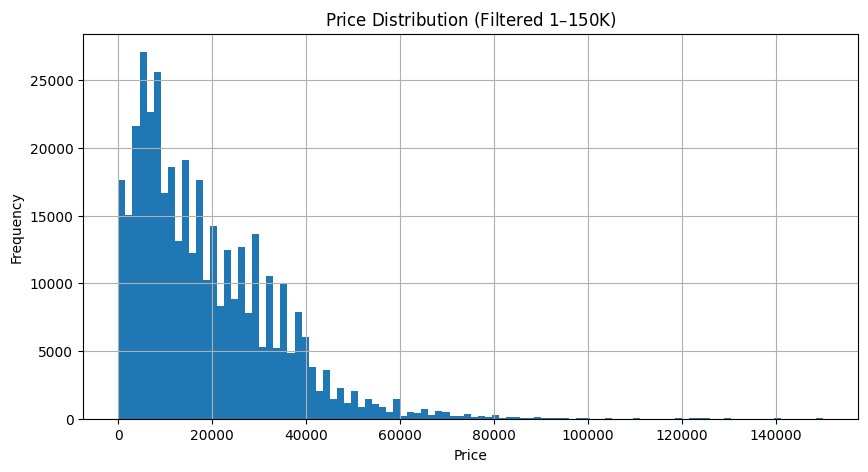

In [11]:
# Filter out unrealistic prices
df_filtered = df[(df['price'] >= 1) & (df['price'] <= 150000)]

# Replot histogram
plt.figure(figsize=(10, 5))
df_filtered['price'].hist(bins=100)
plt.title('Price Distribution (Filtered $1–$150K)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

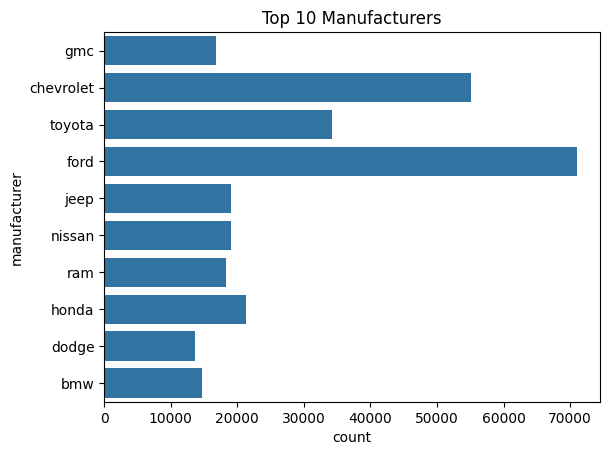

In [12]:
# Countplot for top manufacturers
top_makes = df['manufacturer'].value_counts().nlargest(10).index
sns.countplot(y='manufacturer', data=df[df['manufacturer'].isin(top_makes)])
plt.title('Top 10 Manufacturers')
plt.show()

### **Verify Data**

In [13]:
# Count missing values
print("\nMissing Values (Count and %):\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df)


Missing Values (Count and %):

              Missing Count  Missing %
size                 306361  71.767476
cylinders            177678  41.622470
condition            174104  40.785232
VIN                  161042  37.725356
drive                130567  30.586347
paint_color          130203  30.501078
type                  92858  21.752717
manufacturer          17646   4.133714
title_status           8242   1.930753
model                  5277   1.236179
odometer               4400   1.030735
fuel                   3013   0.705819
transmission           2556   0.598763
year                   1205   0.282281
region                    0   0.000000
id                        0   0.000000
price                     0   0.000000
state                     0   0.000000


In [14]:
# Duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

# Outlier boundaries (basic)
print("Price range:", df['price'].min(), "to", df['price'].max())

Duplicate Rows: 0
Price range: 0 to 3736928711


In [15]:
# Replace '0' VINs with NaN
df['VIN'] = df['VIN'].replace('0', np.nan)

# Filter out placeholder-style VINs that start with '000000'
df = df[~df['VIN'].astype(str).str.startswith('000000')]

# Drop missing VINs
df = df[df['VIN'].notnull()]

# Drop duplicate VINs (same VIN appearing more than once)
df = df.drop_duplicates(subset='VIN', keep='first')

# Re-check final valid VIN stats
valid_vins = df[df['VIN'].notnull()]
duplicate_vins = valid_vins['VIN'].duplicated().sum()

print(f"Valid (non-missing and non-placeholder) VINs: {valid_vins.shape[0]:,}")
print(f"Duplicate VINs (after cleanup): {duplicate_vins:,}")

# Display a few real duplicate examples
if duplicate_vins > 0:
    print("\nSample duplicated VIN entries:")
    display(valid_vins[valid_vins['VIN'].duplicated(keep=False)].sort_values('VIN').head(10))


Valid (non-missing and non-placeholder) VINs: 118,207
Duplicate VINs (after cleanup): 0


In [16]:
# Check how many rows filtered
print("Original dataset rows: 426,880")
print(f"Remaining rows after VIN cleanup: {df.shape[0]}")

# Show how many were dropped
dropped = 426880 - df.shape[0]
print(f"Total rows dropped: {dropped:,} (~{dropped / 426880:.2%})")


Original dataset rows: 426,880
Remaining rows after VIN cleanup: 118207
Total rows dropped: 308,673 (~72.31%)


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [17]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('manufacturer')
list_column_options('model')
list_column_options('condition')
list_column_options('cylinders')
list_column_options('fuel')
list_column_options('drive')
list_column_options('paint_color')
list_column_options('transmission')
list_column_options('type')
list_column_options('title_status')
list_column_options('size')



Unique value counts for 'manufacturer':

manufacturer
ford               18766
chevrolet          14051
toyota             10285
honda               6742
nissan              6094
jeep                5589
ram                 4622
gmc                 4353
bmw                 4129
dodge               3762
hyundai             3518
mercedes-benz       3392
subaru              3351
NaN                 3061
kia                 3008
volkswagen          2706
lexus               2366
audi                2115
cadillac            1921
chrysler            1834
mazda               1630
buick               1514
acura               1454
infiniti            1289
lincoln              998
volvo                877
mitsubishi           824
rover                742
mini                 719
pontiac              487
porsche              474
jaguar               345
saturn               257
mercury              246
fiat                 218
tesla                195
alfa-romeo           160
harley-davidson     

In [18]:
# Drop only truly unnecessary columns if they exist
columns_to_drop = ['id', 'size', "VIN"]
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Fill missing categorical columns
fill_unknown = ['condition', 'cylinders', 'paint_color', 'drive', 'type',
                'title_status', 'manufacturer', 'fuel', 'transmission', 'model']
df[fill_unknown] = df[fill_unknown].fillna('unknown')

# Drop rows where critical numeric fields are missing
df = df[df['year'].notnull()]
df = df[df['odometer'].notnull()]

In [19]:
# Count missing values
print("\nMissing Values (Count and %):\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df)


Missing Values (Count and %):

              Missing Count  Missing %
region                    0        0.0
price                     0        0.0
year                      0        0.0
manufacturer              0        0.0
model                     0        0.0
condition                 0        0.0
cylinders                 0        0.0
fuel                      0        0.0
odometer                  0        0.0
title_status              0        0.0
transmission              0        0.0
drive                     0        0.0
type                      0        0.0
paint_color               0        0.0
state                     0        0.0


### Step: Clean Manufacturer Names

- Merged `'rover'` and `'land rover'` into a single `'land rover'` category
- Dropped 2,166 entries labeled as `'unknown'` since manufacturer is essential for dealership pricing analysis


In [20]:
df['manufacturer'] = df['manufacturer'].replace('rover', 'land rover')
df = df[df['manufacturer'] != 'unknown']

### Step: Clean 'condition' Field

- Dropped 10 `salvage` listings — not suitable for dealership inventory
- Retained `unknown` condition for now (43,693 rows), as these listings still contain useful data like price, mileage, and brand which we will utilize to provide recomendations based off of since it can be subjective anyways.

In [21]:
df = df[df['condition'] != 'salvage']

In [22]:
# Count missing values
print("\nMissing Values (Count and %):\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df)


Missing Values (Count and %):

              Missing Count  Missing %
region                    0        0.0
price                     0        0.0
year                      0        0.0
manufacturer              0        0.0
model                     0        0.0
condition                 0        0.0
cylinders                 0        0.0
fuel                      0        0.0
odometer                  0        0.0
title_status              0        0.0
transmission              0        0.0
drive                     0        0.0
type                      0        0.0
paint_color               0        0.0
state                     0        0.0


In [23]:
# Explore sub-$1000 prices
cheap_cars = df[df['price'] < 1000]
print("Total listings under $1000:", cheap_cars.shape[0])
print(cheap_cars['price'].describe())
print("\nMost common low price values:\n")
print(cheap_cars['price'].value_counts().sort_index().head(10))

Total listings under $1000: 15429
count    15429.000000
mean        88.196513
std        188.881970
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        999.000000
Name: price, dtype: float64

Most common low price values:

price
0     11650
1       145
3         4
5         2
6         1
7         1
9         1
10        1
11        1
13        1
Name: count, dtype: int64


### Step: Remove Listings Priced Under $1000

After exploring the dataset, we found:
- 15,614 cars were listed below $1000

- 11,771 of those were exactly $0

- Most sub-$1000 listings are placeholders, spam, or non-retail offerings

#### Business Reason:
Since our client is a used car dealership, vehicles priced under $1000 are not relevant to their typical inventory or customer market. Including these listings would distort insights and reduce the models relevance for their pricing strategy.

#### Decision:
We filtered out all listings with `price < $1000`:


In [24]:
df = df[df['price'] >= 1000]

### Step: Filter to Only 'Clean' Title Vehicles

Since our client is a used car dealership, we filtered out all vehicles that do not have a clean title. These include:

- Rebuilt
- Salvage
- Lien
- Parts only
- Missing or unknown titles

This ensures we are only analyzing inventory that would actually be relevant to the dealership.



In [25]:
df = df[df['title_status'] == 'clean']

In [26]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('manufacturer')
list_column_options('model')
list_column_options('condition')
list_column_options('cylinders')
list_column_options('fuel')
list_column_options('drive')
list_column_options('paint_color')
list_column_options('transmission')
list_column_options('type')
list_column_options('title_status')
list_column_options('size')



Unique value counts for 'manufacturer':

manufacturer
ford               15416
chevrolet          11451
toyota              8242
honda               5394
nissan              4796
jeep                4405
ram                 3696
gmc                 3525
bmw                 3426
dodge               2928
hyundai             2829
mercedes-benz       2809
subaru              2756
kia                 2396
volkswagen          2235
lexus               2002
audi                1769
cadillac            1567
chrysler            1494
mazda               1270
buick               1253
acura               1174
infiniti            1064
lincoln              833
volvo                776
mitsubishi           675
land rover           622
mini                 609
pontiac              436
porsche              398
jaguar               296
saturn               225
mercury              218
fiat                 180
tesla                156
alfa-romeo           141
harley-davidson       49
ferrari             

Create Car Age Feature:

Provides easier way for user to digest the data in terms of age rather than having to calculate.

In [27]:
df['car_age'] = 2025 - df['year']

 Log Transformation: Create log_price
 Why?

- Car prices have a wide range (e.g., $1,000 to over $100,000)
- A few luxury cars or pricing errors can distort the model
- Models like Linear Regression assume that the data follows a normal distribution

Business Insight:

This helps the model better understand average pricing behavior without being biased by luxury vehicles

In [28]:
df['log_price'] = np.log1p(df['price'])

Simplify Car Models

Model column has over 13,000 unique values

In [29]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('model')


Unique value counts for 'model':

model
f-150                      2199
silverado 1500             1299
1500                       1065
escape                      886
camry                       842
                           ... 
passat 2.0t se auto           1
panamera 4s                   1
mazdaspeed6                   1
mustang convertable           1
benz 560 sl convertible       1
Name: count, Length: 13004, dtype: int64


In [37]:
# STEP 1: Normalize model strings
df['model'] = df['model'].astype(str).str.lower().str.strip()
df['model'] = df['model'].str.replace(r'[^\w\s\-]', '', regex=True)

# STEP 2: Replace known dirty strings
specific_model_map = {
    'sierra 1500 4x4 v6': 'sierra 1500',
    '2500 67 cummins diesel 4x4 laramie leveled 35s': 'silverado 2500',
    'explorer limited front wheel drive w4x4': 'explorer',
    'f350 4wd drw 1owner rust free tx truck': 'f-350'
}
df['model'] = df['model'].replace(specific_model_map)

# STEP 3: Basic exact mapping dictionary
model_map = {
    'f150': 'f-150',
    'f 150': 'f-150',
    'accord lx': 'accord',
    # Add more if needed
}
df['model'] = df['model'].replace(model_map)

# STEP 4: Trim and match
trims_and_specs = [
    'lx', 'le', 'se', 'xle', 'xlt', 'ex', 'exl', 'limited', 'platinum', 'base', 'sport', 'premium',
    'touring', 'awd', 'fwd', 'rwd', '4wd', '4x4', 'eco', 'z71', 'lariat', 'crew cab', 'supercab',
    'convertible', 'hatchback', 'sedan', 'coupe', 'manual', 'automatic', 'hybrid', 'diesel', 'gas',
    'v6', 'v8', '6 cyl', '8 cyl', 'dr', '2dr', '4dr', 'passenger', 'cab', 'sl', 'sv', 'lt', 'ls',
    'rz', 'rzr', 'plus', 'rs', 'es', 's', 'z', 'ti', 'dx', 'gx', 'tx', 'hx', 'gt', 'gti', 'gts',
    'pzev', 'titanium', 'trailhawk', 'overland', 'longhorn', 'laredo', 'srt', 'l', 'xl', 't', 'cvti'
]

base_models = [
    'f-150', 'f-250', 'f-350', 'silverado 1500', 'silverado 2500', 'silverado 3500', 'camry',
    'corolla', 'civic', 'accord', 'altima', 'sentra', 'explorer', 'escape', 'fusion', 'wrangler',
    'grand cherokee', 'malibu', 'rav4', 'cr-v', 'elantra', 'sonata', 'outback', 'tacoma', 'tundra',
    'sierra 1500', 'sierra 2500', 'sierra 3500', 'mustang', 'impala', 'focus', 'pilot', 'odyssey',
    'pathfinder', 'rogue', 'murano', 'rio', 'soul', 'forte', 'optima', 'sienna'
]

def trim_and_match_model(model):
    model_cleaned = re.sub(r'\b(' + '|'.join(trims_and_specs) + r')\b', '', model)
    model_cleaned = re.sub(r'\s+', ' ', model_cleaned).strip()
    for base in base_models:
        if base in model_cleaned:
            return base
    return model_cleaned  # fallback

df['model'] = df['model'].apply(trim_and_match_model)

print("Unique models after cleaning:", df['model'].nunique())
print(df['model'].value_counts().head(20))

# top_models = df['model'].value_counts().nlargest(50).index
# df['model'] = df['model'].where(df['model'].isin(top_models), 'other')

Unique models after cleaning: 200
model
other             27522
f-150              3031
silverado 1500     2048
wrangler           1589
camry              1308
civic              1291
accord             1287
escape             1254
1500               1187
grand cherokee     1076
explorer           1059
tacoma             1053
f-250              1038
altima              957
corolla             944
fusion              932
cr-v                902
focus               845
equinox             813
sierra 1500         807
Name: count, dtype: int64


In [38]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('model')


Unique value counts for 'model':

model
other                27522
f-150                 3031
silverado 1500        2048
wrangler              1589
camry                 1308
                     ...  
q50                     70
m-class                 69
edge sel                69
grand caravan sxt       69
genesis                 68
Name: count, Length: 200, dtype: int64


In [39]:
# Keep top N most common models — adjust N as needed
top_n = 200  # 200 to preserve more detail
top_models = df['model'].value_counts().nlargest(top_n).index

# Replace everything else with 'other'
df['model'] = df['model'].where(df['model'].isin(top_models), 'other')

# Review final output
print("Unique models after grouping:", df['model'].nunique())
print(df['model'].value_counts().head(20))


Unique models after grouping: 200
model
other             27522
f-150              3031
silverado 1500     2048
wrangler           1589
camry              1308
civic              1291
accord             1287
escape             1254
1500               1187
grand cherokee     1076
explorer           1059
tacoma             1053
f-250              1038
altima              957
corolla             944
fusion              932
cr-v                902
focus               845
equinox             813
sierra 1500         807
Name: count, dtype: int64


In [40]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('model')


Unique value counts for 'model':

model
other                27522
f-150                 3031
silverado 1500        2048
wrangler              1589
camry                 1308
                     ...  
q50                     70
m-class                 69
edge sel                69
grand caravan sxt       69
genesis                 68
Name: count, Length: 200, dtype: int64


In [34]:
# generates the model csv for easier processing for the model map
# df['model'].value_counts().to_csv('model_counts.csv')

Encode Categorical Variables
- Categorical variable: A variable that contains labels instead of numbers (e.g., fuel = gas, diesel, electric)

- Encoding: Converting categorical labels into numbers that a model can understand

- One-hot encoding: Converts each category into its own column with binary values (0 or 1)

In [41]:
# Create 'region_grouped' column before one-hot encoding
top_regions = df['region'].value_counts().nlargest(10).index
df['region_grouped'] = df['region'].where(df['region'].isin(top_regions), 'other')

# Set up column categories
categorical_cols = [
    'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
    'drive', 'paint_color', 'transmission', 'type', 'state', 'region_grouped', 'title_status'
]
numerical_cols = ['odometer', 'car_age']



### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Prepare Features and Target

Split Data into Training and Test Sets

In [42]:
# Separate target and predictors
X = df.drop(columns=['price', 'log_price', 'year'])
y = df['log_price']

# One-hot encoder without dropping any levels
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# ColumnTransformer to scale numeric and encode categoricals
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', ohe, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Choose Regression Models

In [43]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
}

# Initialize result storage
results = {}
coefs = {}
fitted_pipelines = {}

Optimize the alphas:

In [44]:
# Define Ridge pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Define parameter grid
ridge_params = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Run GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)

# Best model and alpha
best_ridge = ridge_grid.best_estimator_
print("Best Ridge alpha:", ridge_grid.best_params_['regressor__alpha'])

Best Ridge alpha: 1.0


In [46]:
from sklearn.linear_model import LassoCV
# Define LassoCV pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(
        alphas=[0.000001, 0.00001, 0.0001, 0.001],
        cv=5,
        max_iter=10000,
        tol=0.01,
        random_state=42
    ))
])

# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Extract best alpha
best_lasso = lasso_pipeline.named_steps['regressor'].alpha_
print("Best Lasso alpha (via LassoCV):", best_lasso)

Best Lasso alpha (via LassoCV): 1e-05


In [47]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=ridge_grid.best_params_['regressor__alpha']),
    'Lasso Regression': Lasso(alpha=best_lasso),
}

Train & Evaluate Each Model

In [48]:
# Train models and store results
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Scores
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2').mean()

    results[name] = {'RMSE': rmse, 'R²': r2, 'CV R² (5-fold)': cv_r2}
    fitted_pipelines[name] = pipeline

    # Get full feature names
    feature_names = (
        numerical_cols +
        list(pipeline.named_steps['preprocessor']
             .named_transformers_['cat']
             .get_feature_names_out())
    )

    # Store all coefficients
    coef_series = pd.Series(pipeline.named_steps['regressor'].coef_, index=feature_names)
    coefs[name] = coef_series

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [49]:
# Build results table
results_df = pd.DataFrame(results).T.sort_values(by='CV R² (5-fold)', ascending=False)
print(results_df)

# Build full coefficient comparison table
coef_df = pd.DataFrame(coefs).fillna(0)  # Fill NAs for missing features in Lasso, etc.
coef_df = coef_df.loc[coef_df.abs().max(axis=1).sort_values(ascending=False).index]  # Sort by max influence

# Show top 20 most influential features across all models
print("\nTop 20 features across all models by absolute coefficient value:")
print(coef_df.head(20))

# Optional: export
coef_df.to_csv("model_coefficients_comparison.csv")
results_df.to_csv("model_results_summary.csv")

                       RMSE        R²  CV R² (5-fold)
Ridge Regression   0.434514  0.668676        0.459558
Linear Regression  0.434508  0.668686        0.459546
Lasso Regression   0.434517  0.668671        0.458067

Top 20 features across all models by absolute coefficient value:
                           Linear Regression  Ridge Regression  \
manufacturer_datsun                 1.527508          1.341926   
manufacturer_ferrari                1.470075          1.402563   
model_cobalt                       -0.940274         -0.924997   
manufacturer_porsche                0.759332          0.761893   
model_corvette                      0.746001          0.743962   
manufacturer_saturn                -0.744939         -0.732150   
model_hhr                          -0.713350         -0.699068   
model_fiesta                       -0.705787         -0.697838   
manufacturer_tesla                  0.635199          0.635961   
condition_fair                     -0.584916         -0.58

In [50]:
print(results_df)
print("\nTop predictors for each model:")

for name, coef_series in coefs.items():
    print(f"\n{name} top 10 predictors:")
    print(coef_series.sort_values(key=abs, ascending=False).head(10))

                       RMSE        R²  CV R² (5-fold)
Ridge Regression   0.434514  0.668676        0.459558
Linear Regression  0.434508  0.668686        0.459546
Lasso Regression   0.434517  0.668671        0.458067

Top predictors for each model:

Linear Regression top 10 predictors:
manufacturer_datsun     1.527508
manufacturer_ferrari    1.470075
model_cobalt           -0.940274
manufacturer_porsche    0.759332
model_corvette          0.746001
manufacturer_saturn    -0.744939
model_hhr              -0.713350
model_fiesta           -0.705787
model_pt cruiser       -0.661038
model_fj cruiser        0.649841
dtype: float64

Ridge Regression top 10 predictors:
manufacturer_ferrari    1.402563
manufacturer_datsun     1.341926
model_cobalt           -0.924997
manufacturer_porsche    0.761893
model_corvette          0.743962
manufacturer_saturn    -0.732150
model_hhr              -0.699068
model_fiesta           -0.697838
model_pt cruiser       -0.648020
model_fj cruiser        0.637956
dt

The Ridge and Linear are nearly identical due to the data cleaning which eliminated a lot of potential noise.

## Ridge vs. Linear in Practice
### Linear Regression:
Good for small feature sets, when interpretability matters most

Pros:
- Super fast and simple
- Directly shows how each feature affects the target (clear coefficients)
- Easy to explain to non-technical audiences

Cons:
- Assumes features are not too correlated
- Can produce unstable results if there is noise or many features
- Easily overfits on high-dimensional data

### Ridge Regression:
Good for large or messy feature sets, especially post-one-hot-encoding

Pros:
- Shrinks coefficients to prevent overfitting
- Handles multicollinearity (correlated predictors)
- Better performance on new/unseen data
- Especially useful after one-hot encoding 50+ features

Cons:
- Coefficients are “shrunk,” making them harder to interpret
- Still keeps all features (unlike Lasso, which drops some)

Even though performance metrics are nearly identical, I selected Ridge Regression as the preferred model for the client because it is better suited to large, one-hot-encoded datasets like this one and provides more stability when generalizing to future car listings.  However, I am using Linear for the categorical analysis.

In [51]:
ridge_pipeline = fitted_pipelines['Ridge Regression']
# Use the fitted preprocessor from Ridge
feature_names = (
    numerical_cols +
    list(ridge_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out())
)

# Get coefficients from trained Ridge model
ridge_coefs = pd.Series(ridge_pipeline.named_steps['regressor'].coef_, index=feature_names)

# Show top 20
print(ridge_coefs.sort_values(key=abs, ascending=False).head(20))

manufacturer_ferrari         1.402563
manufacturer_datsun          1.341926
model_cobalt                -0.924997
manufacturer_porsche         0.761893
model_corvette               0.743962
manufacturer_saturn         -0.732150
model_hhr                   -0.699068
model_fiesta                -0.697838
model_pt cruiser            -0.648020
model_fj cruiser             0.637956
manufacturer_tesla           0.635961
model_sonic                 -0.629359
model_focus                 -0.626780
model_spark                 -0.625716
condition_fair              -0.583780
model_trailblazer           -0.580584
model_g6                    -0.577877
model_sebring               -0.546446
manufacturer_mitsubishi     -0.545617
manufacturer_aston-martin    0.528526
dtype: float64


In [52]:
# Use the fitted preprocessor from Ridge
feature_names = (
    numerical_cols +
    list(ridge_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out())
)

# Get coefficients from trained Ridge model
ridge_coefs = pd.Series(ridge_pipeline.named_steps['regressor'].coef_, index=feature_names)

# Sort and display top 100 predictors by absolute value
ridge_coefs_sorted = ridge_coefs.sort_values(key=abs, ascending=False)
print(ridge_coefs_sorted.head(100))

manufacturer_ferrari       1.402563
manufacturer_datsun        1.341926
model_cobalt              -0.924997
manufacturer_porsche       0.761893
model_corvette             0.743962
                             ...   
manufacturer_nissan       -0.220261
model_outlander            0.219461
manufacturer_volkswagen   -0.215557
model_1500 laramie         0.215186
model_durango              0.214317
Length: 100, dtype: float64


In [53]:
import os

# Define the directory path
save_directory = '/content/drive/MyDrive/data'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the full file path
file_path = os.path.join(save_directory, 'ridge_regression_coefficients.csv')

# Save coefficients to CSV
coefficients_sorted.to_csv(file_path, header=['coefficient'])

print(f"\nRidge Regression coefficients saved to {file_path}")

NameError: name 'coefficients_sorted' is not defined

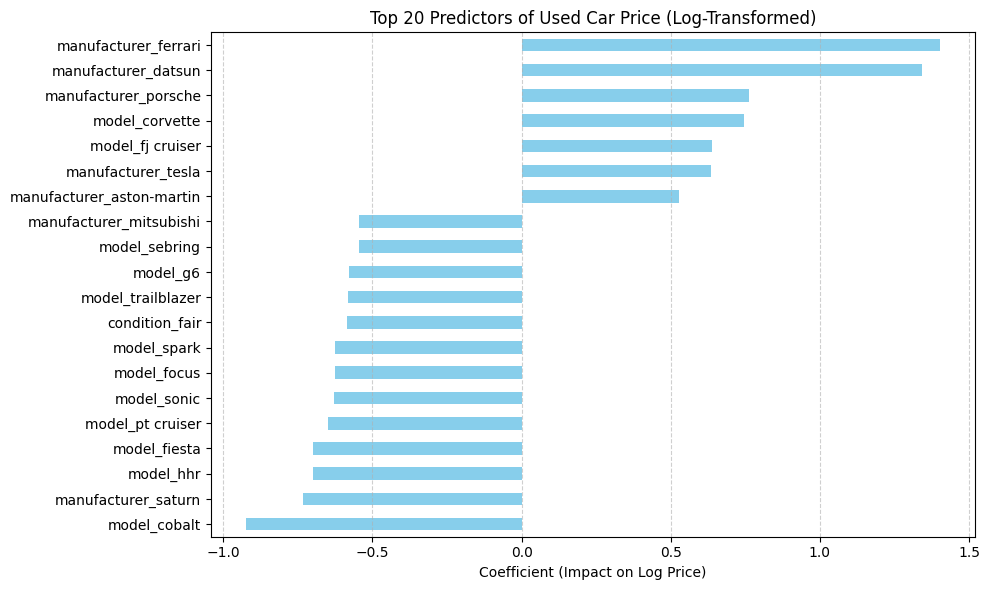

In [54]:
# Plot top 20 predictors (by absolute impact on log price)
top_20 = ridge_coefs_sorted.head(20)

plt.figure(figsize=(10, 6))
top_20.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Coefficient (Impact on Log Price)')
plt.title('Top 20 Predictors of Used Car Price (Log-Transformed)')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [55]:
# Sets a threshold for “non-zero”
threshold = 0.000001

nonzero_coefs = ridge_coefs[ridge_coefs.abs() > threshold].sort_values(key=abs, ascending=False)
print(nonzero_coefs)

manufacturer_ferrari                 1.402563
manufacturer_datsun                  1.341926
model_cobalt                        -0.924997
manufacturer_porsche                 0.761893
model_corvette                       0.743962
                                       ...   
model_sorento                       -0.002109
region_grouped_portland              0.001819
paint_color_red                      0.001598
region_grouped_anchorage / mat-su    0.001492
model_crv                            0.001066
Length: 360, dtype: float64


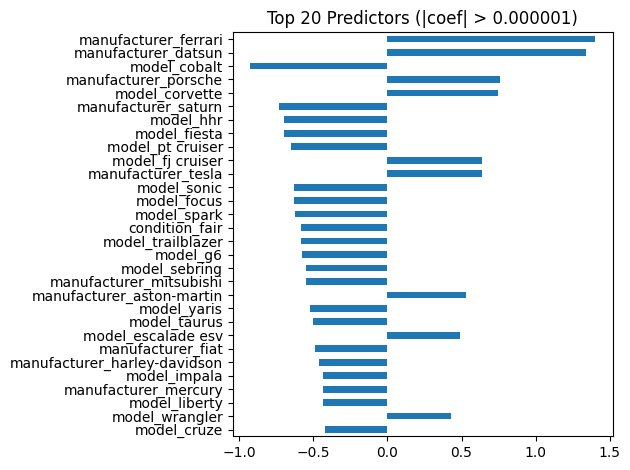

In [56]:
nonzero_coefs.head(30).plot(kind='barh', title='Top 20 Predictors (|coef| > 0.000001)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [57]:
car_age_coef = ridge_coefs.get('car_age', None)

if car_age_coef is not None:
    depreciation_rate = np.expm1(-car_age_coef)
    print(f"Estimated average annual depreciation: {depreciation_rate:.2%}")
else:
    print("car_age coefficient not found.")

Estimated average annual depreciation: 36.46%


In [58]:
odometer_coef = ridge_coefs.get('odometer', None)

if odometer_coef is not None:
    depreciation_rate = np.expm1(-odometer_coef)
    print(f"Estimated average annual depreciation: {depreciation_rate:.2%}")
else:
    print("odometer coefficient not found.")

Estimated average annual depreciation: 17.75%


In [59]:
drive_fwd_coef = ridge_coefs.get('drive_fwd', None)

if drive_fwd_coef is not None:
    depreciation_rate = np.expm1(-drive_fwd_coef)
    print(f"Estimated average annual depreciation: {depreciation_rate:.2%}")
else:
    print("drive_fwd coefficient not found.")

Estimated average annual depreciation: 11.31%


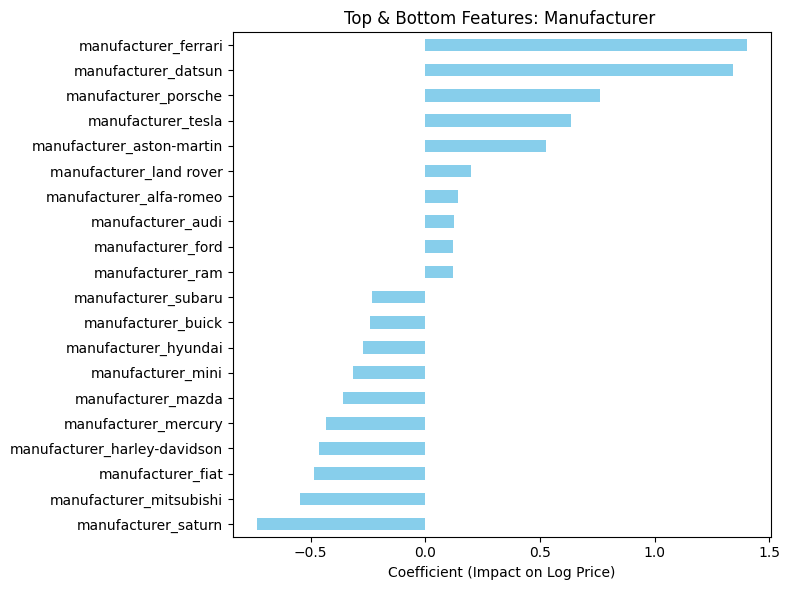

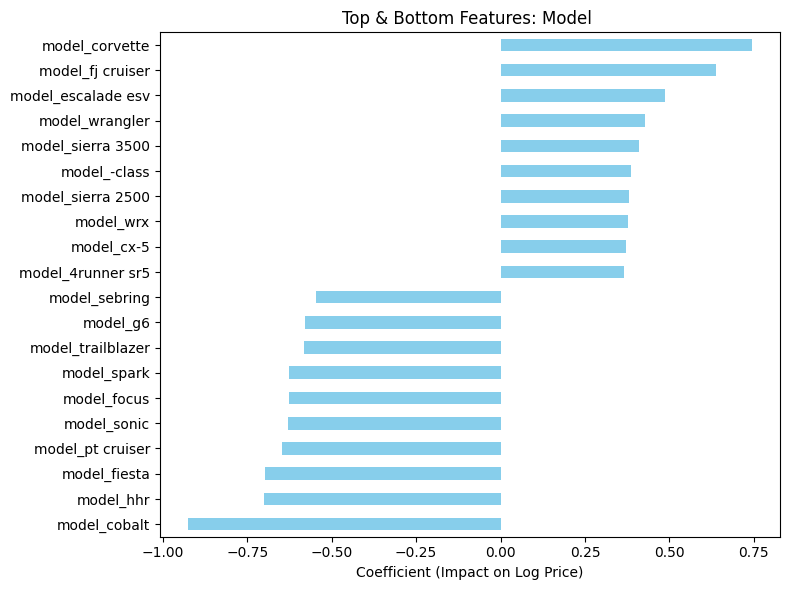

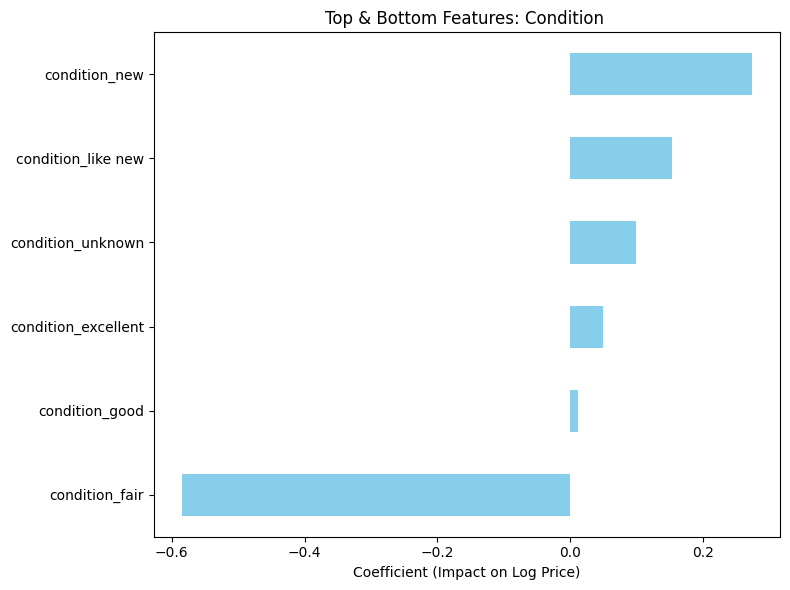

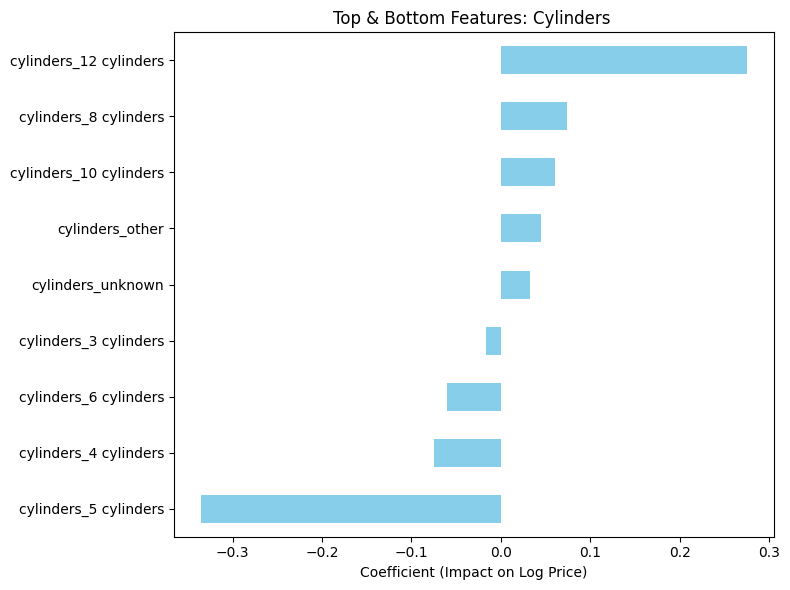

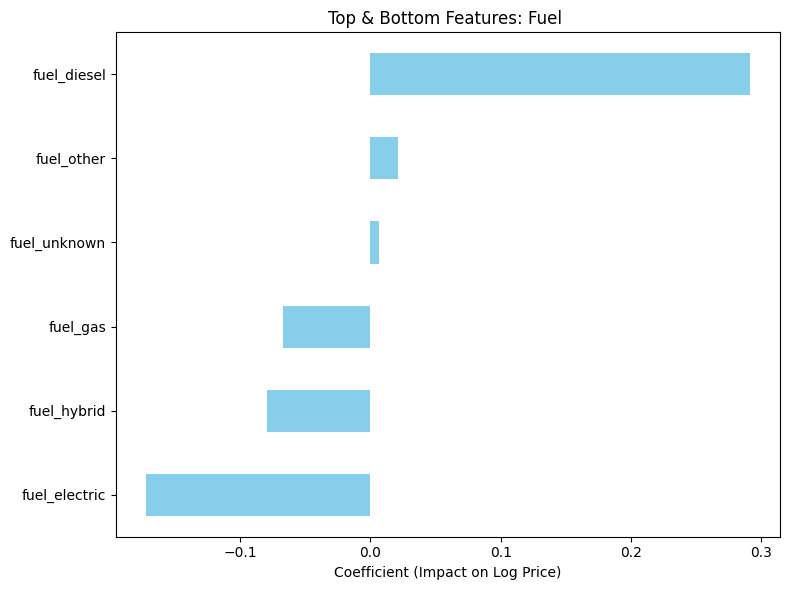

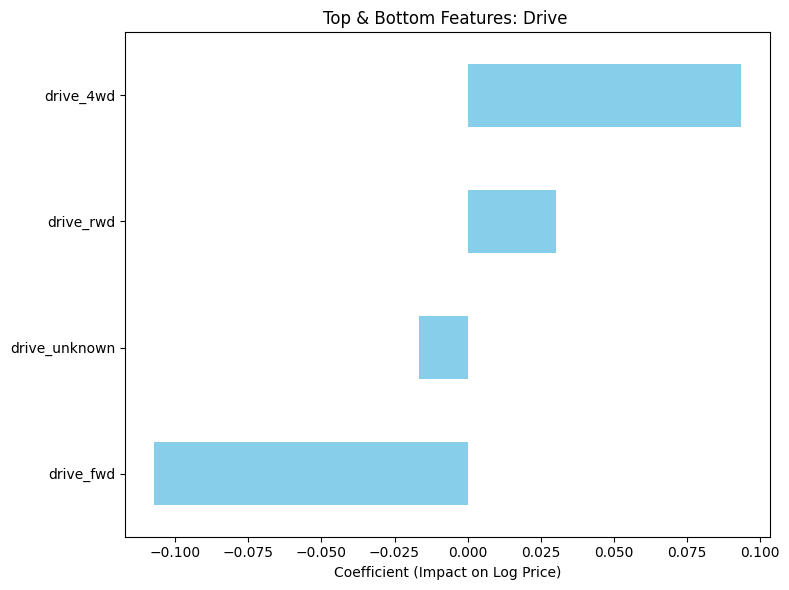

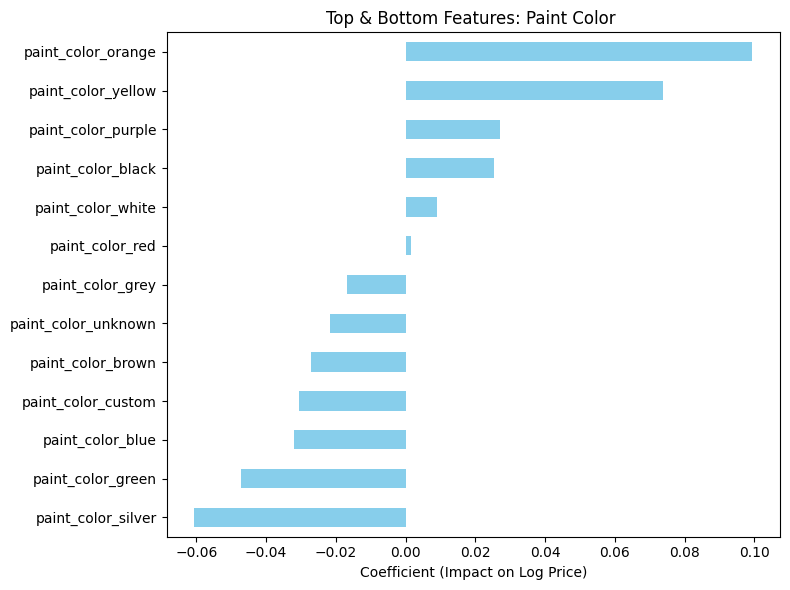

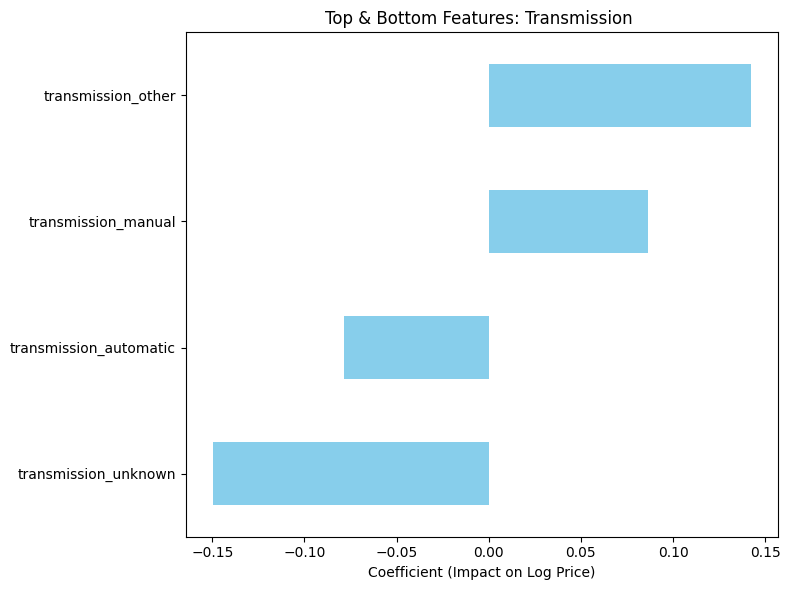

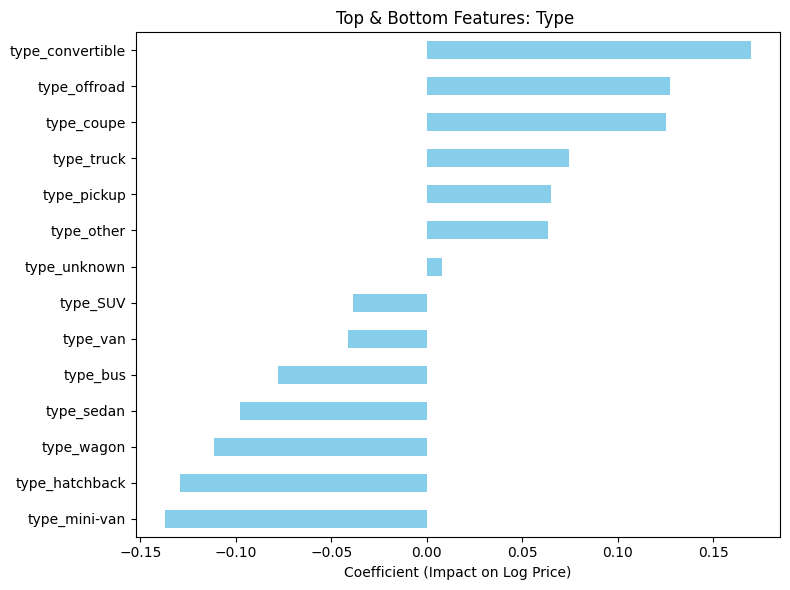

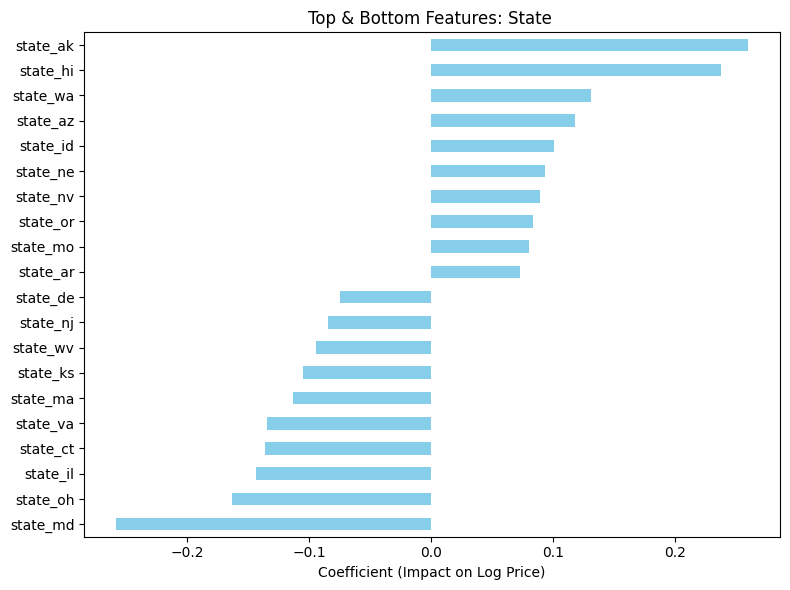

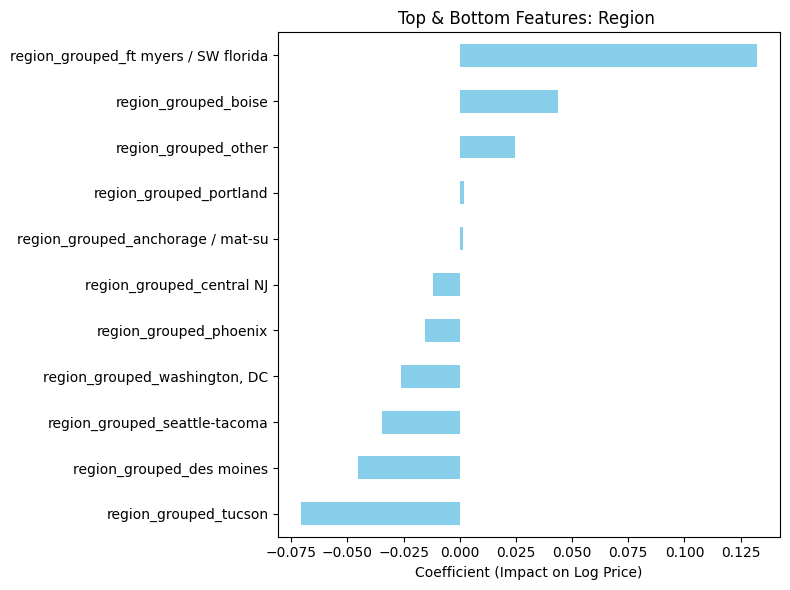

In [75]:
# Define feature group prefixes
group_prefixes = [
    'manufacturer_', 'model_', 'condition_', 'cylinders_', 'fuel_',
    'drive_', 'paint_color_', 'transmission_', 'type_', 'state_', 'region_'  # Adjusted from region_grouped_
]

# Plot top 10 and bottom 10 by group without duplicates
features_by_group = {}
for prefix in group_prefixes:
    group_coeffs = ridge_coefs[ridge_coefs.index.str.startswith(prefix)]
    if not group_coeffs.empty:
        sorted_group = group_coeffs.sort_values()
        if len(sorted_group) <= 20:
            top_bottom = sorted_group
        else:
            top_bottom = pd.concat([sorted_group.head(10), sorted_group.tail(10)]).drop_duplicates()
        features_by_group[prefix] = top_bottom

# Plotting
for prefix, series in features_by_group.items():
    plt.figure(figsize=(8, 6))
    series.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top & Bottom Features: {prefix.replace('_', ' ').title()}")
    plt.xlabel("Coefficient (Impact on Log Price)")
    plt.tight_layout()
    plt.show()

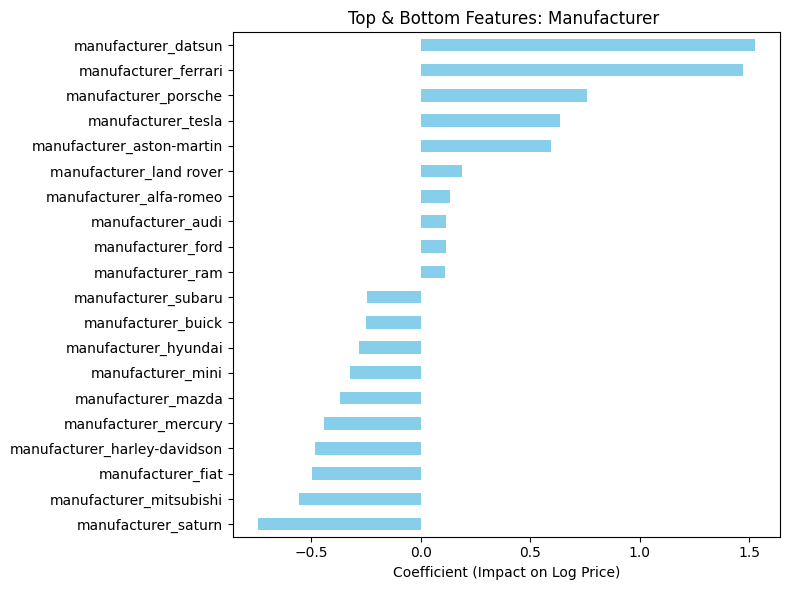

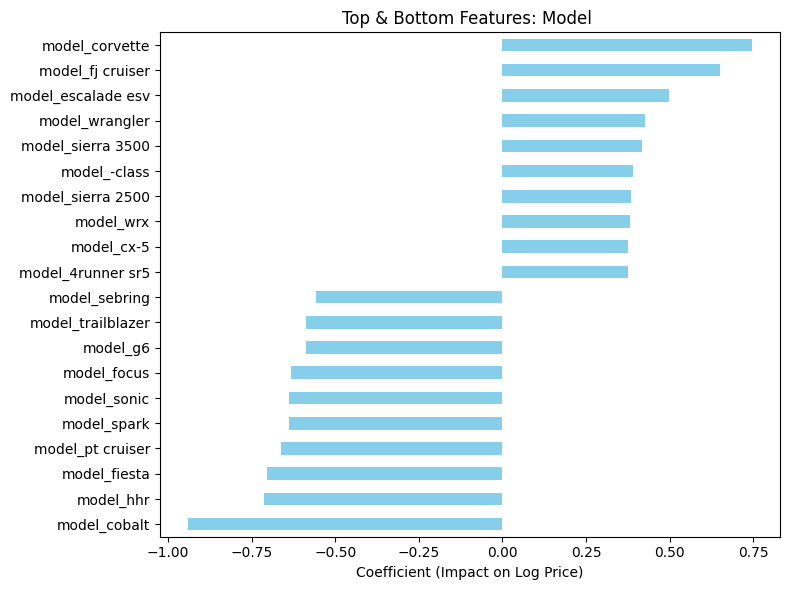

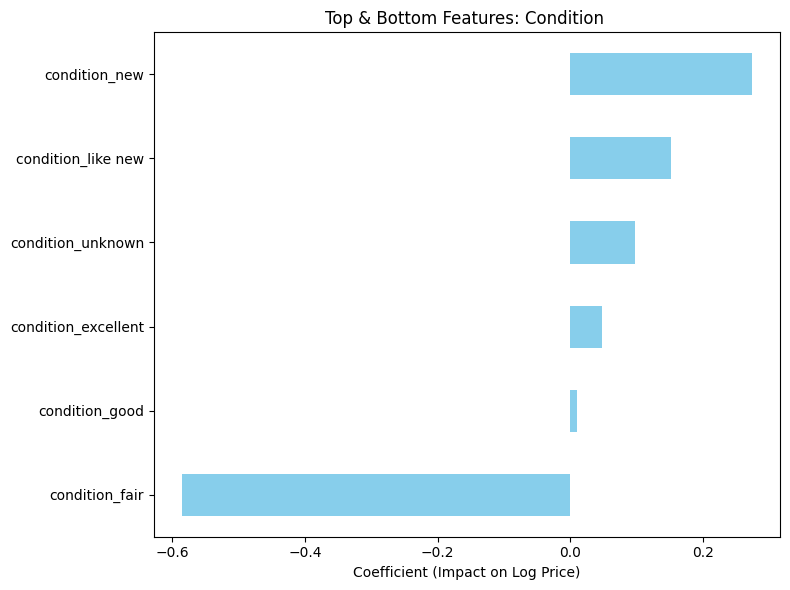

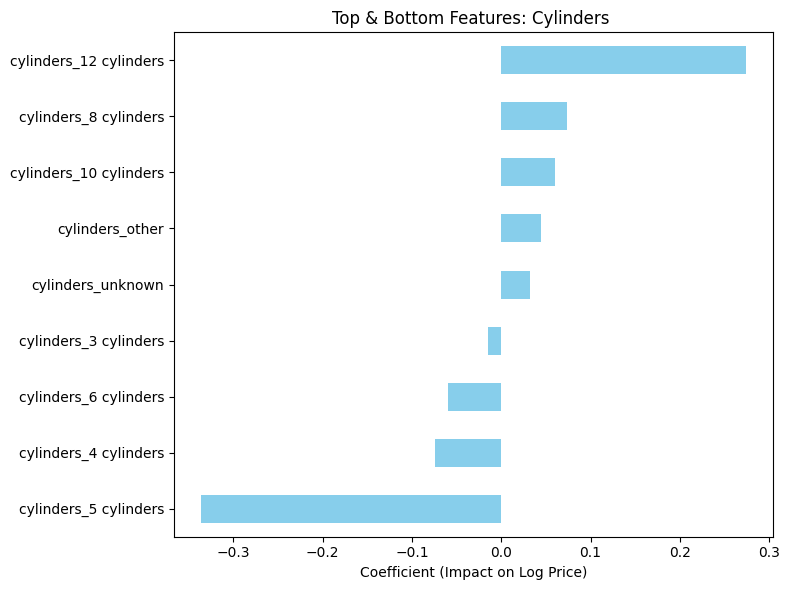

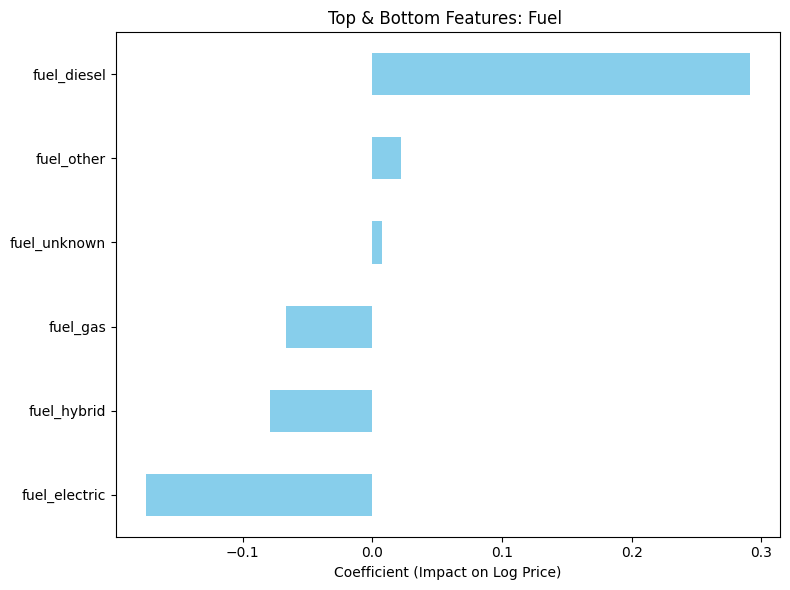

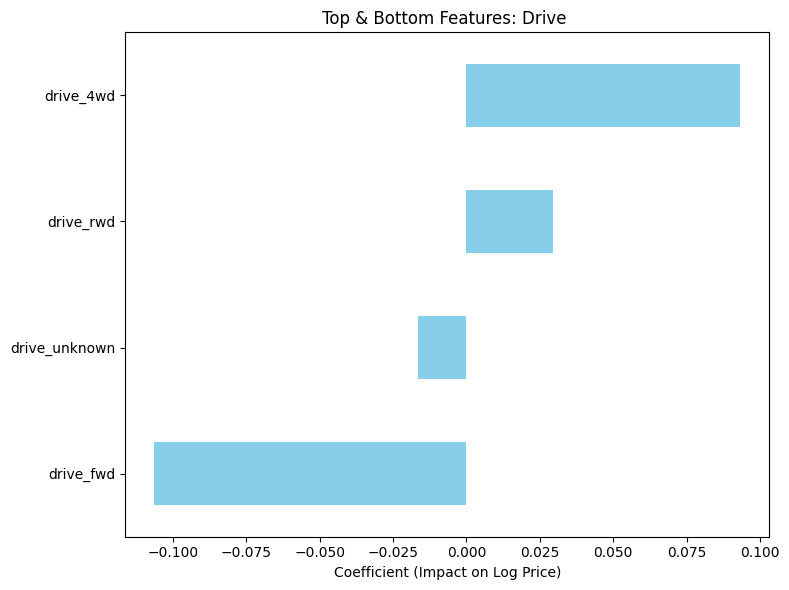

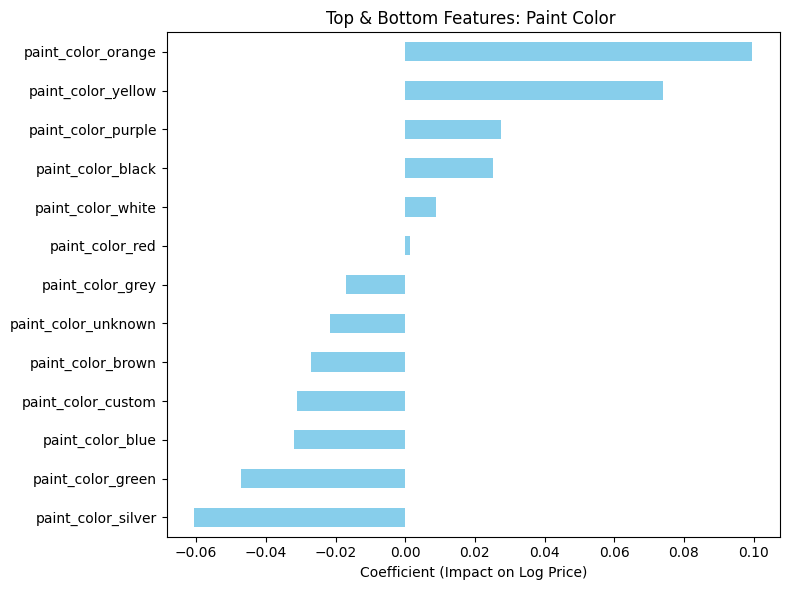

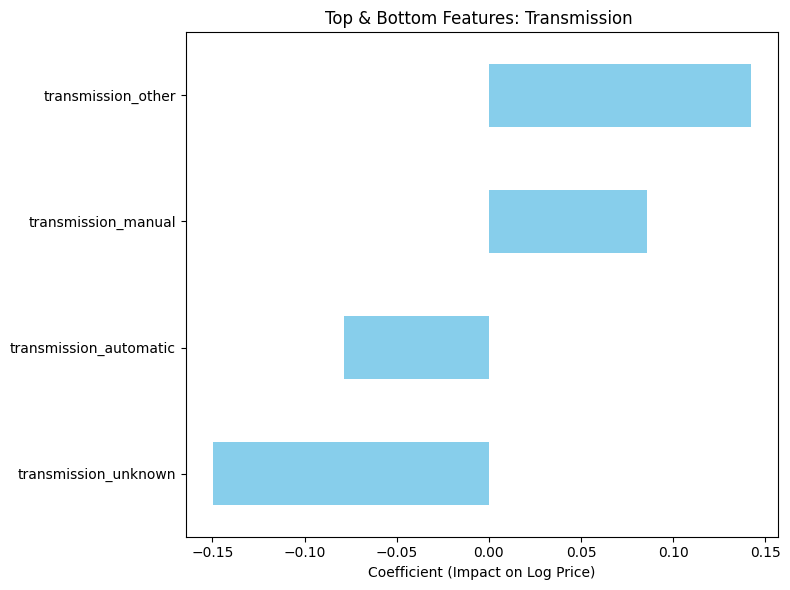

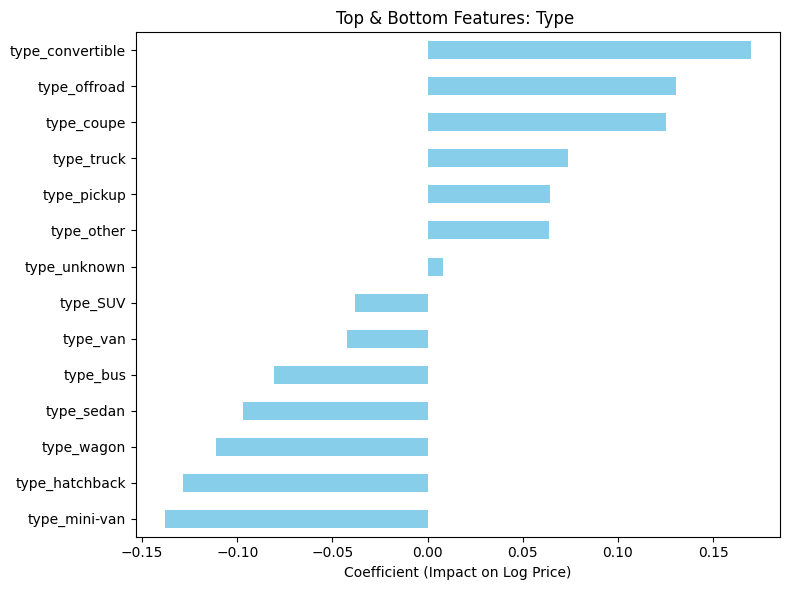

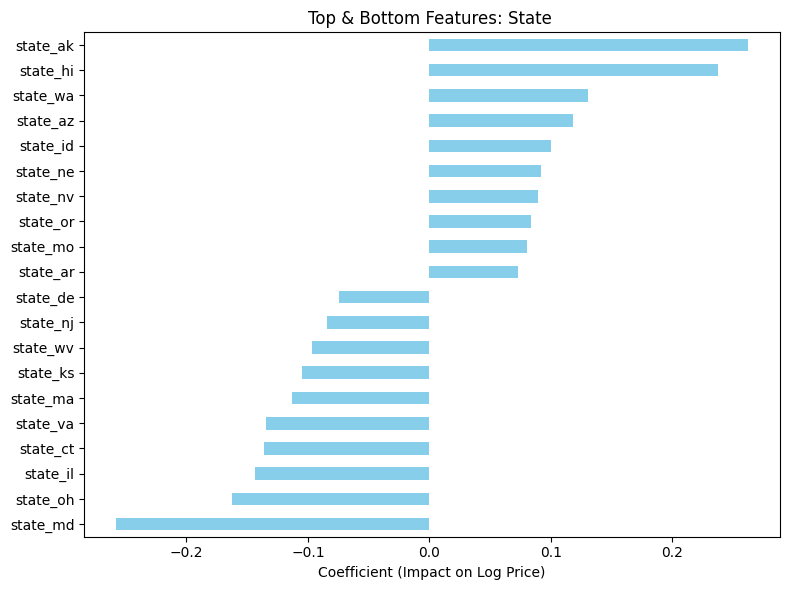

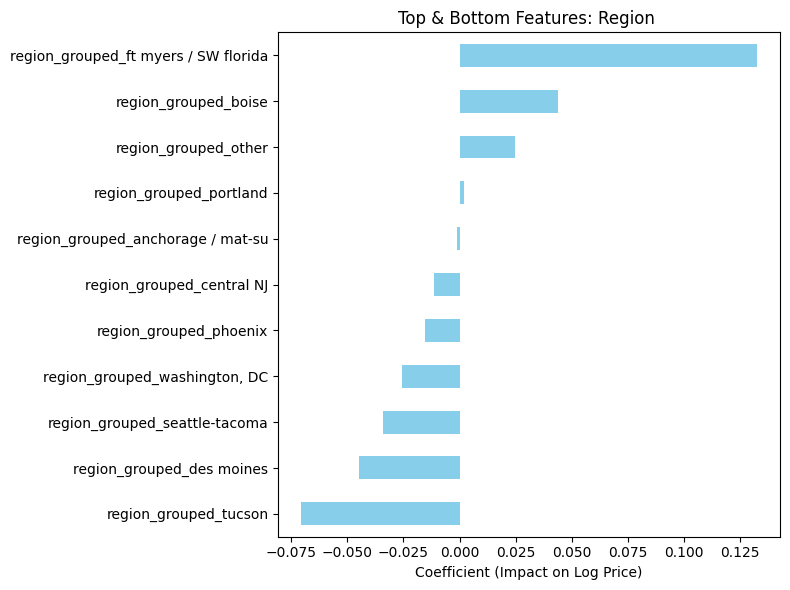

In [61]:
# Retrieve trained pipeline
pipeline_linear = fitted_pipelines['Linear Regression']

# Get feature names from fitted preprocessor
feature_names = numerical_cols + list(
    pipeline_linear.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out()
)

# Get coefficients from trained model
linear_coefs = pd.Series(pipeline_linear.named_steps['regressor'].coef_, index=feature_names)

# Define feature group prefixes
group_prefixes = [
    'manufacturer_', 'model_', 'condition_', 'cylinders_', 'fuel_',
    'drive_', 'paint_color_', 'transmission_', 'type_', 'state_', 'region_'  # Adjusted from region_grouped_
]

# Plot top 10 and bottom 10 by group without duplicates
features_by_group = {}
for prefix in group_prefixes:
    group_coeffs = linear_coefs[linear_coefs.index.str.startswith(prefix)]
    if not group_coeffs.empty:
        sorted_group = group_coeffs.sort_values()
        if len(sorted_group) <= 20:
            top_bottom = sorted_group
        else:
            top_bottom = pd.concat([sorted_group.head(10), sorted_group.tail(10)]).drop_duplicates()
        features_by_group[prefix] = top_bottom

# Plotting
for prefix, series in features_by_group.items():
    plt.figure(figsize=(8, 6))
    series.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top & Bottom Features: {prefix.replace('_', ' ').title()}")
    plt.xlabel("Coefficient (Impact on Log Price)")
    plt.tight_layout()
    plt.show()


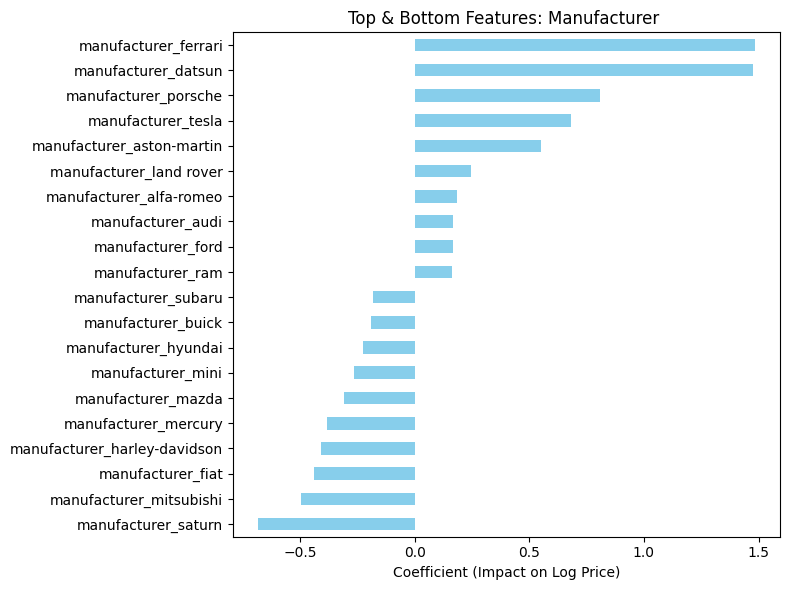

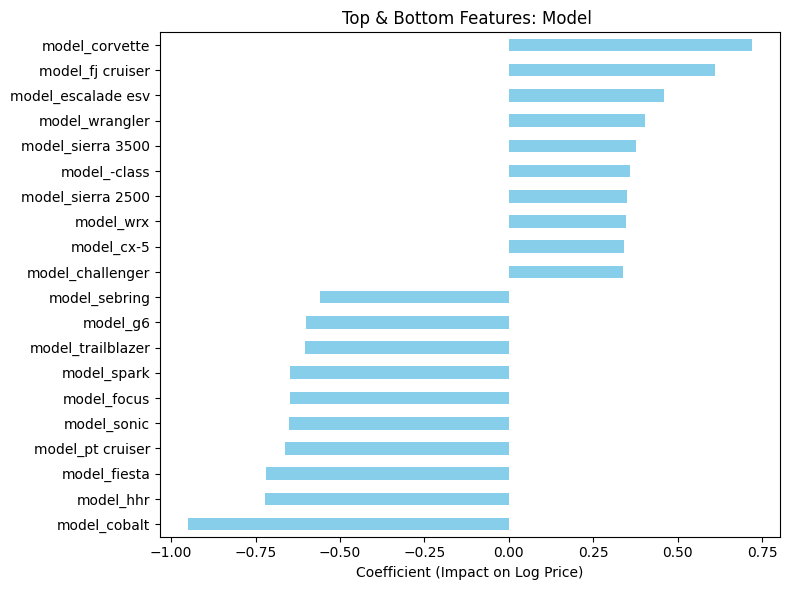

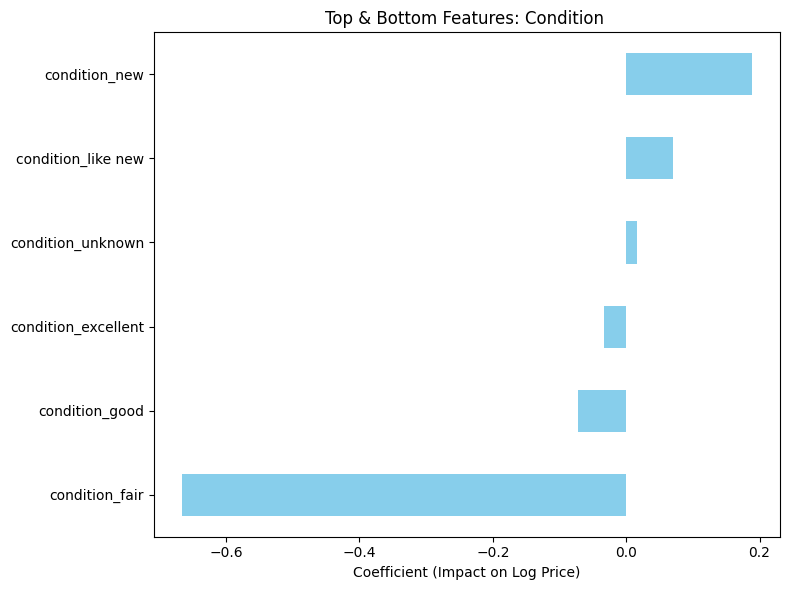

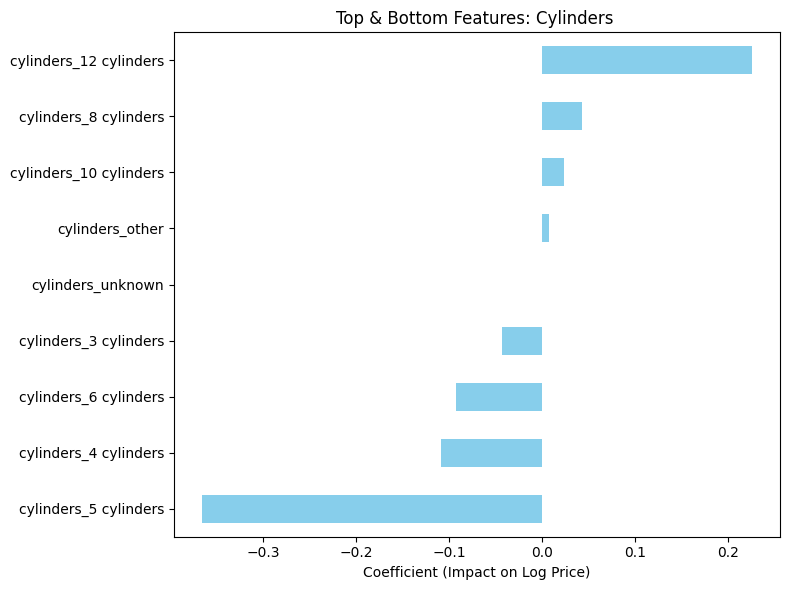

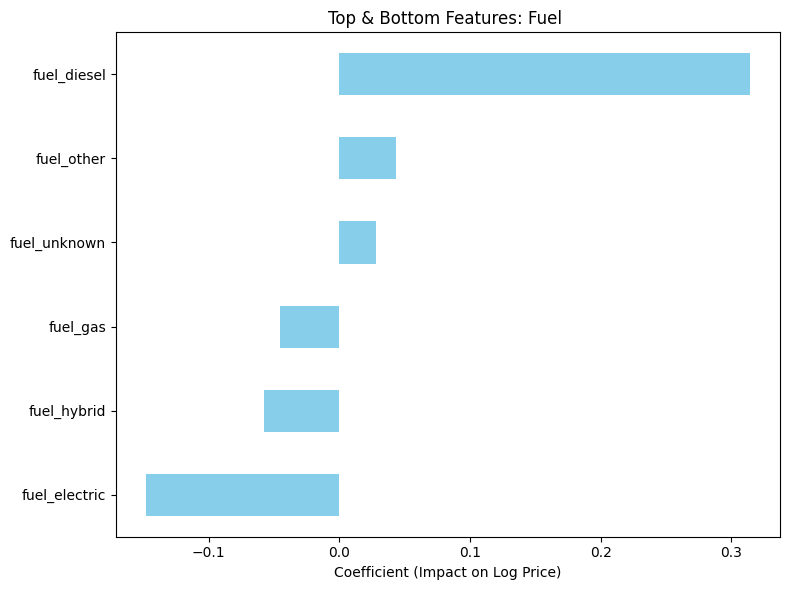

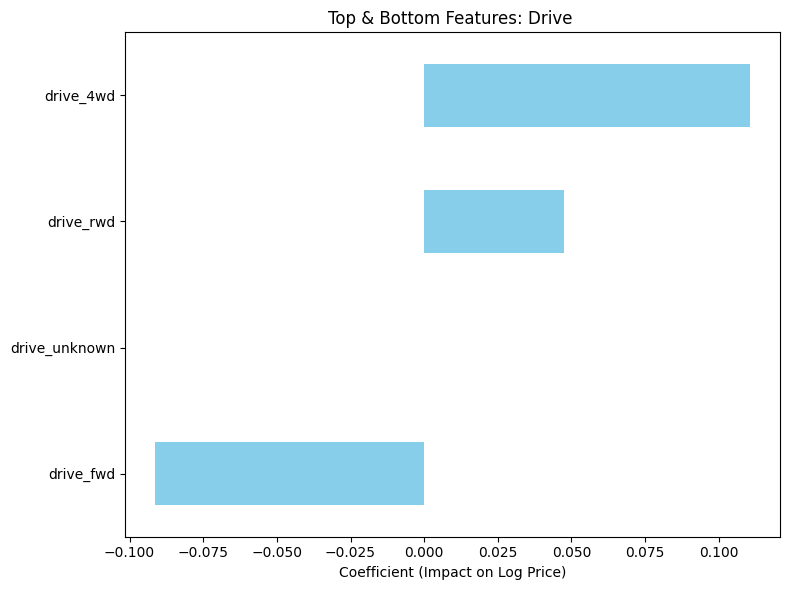

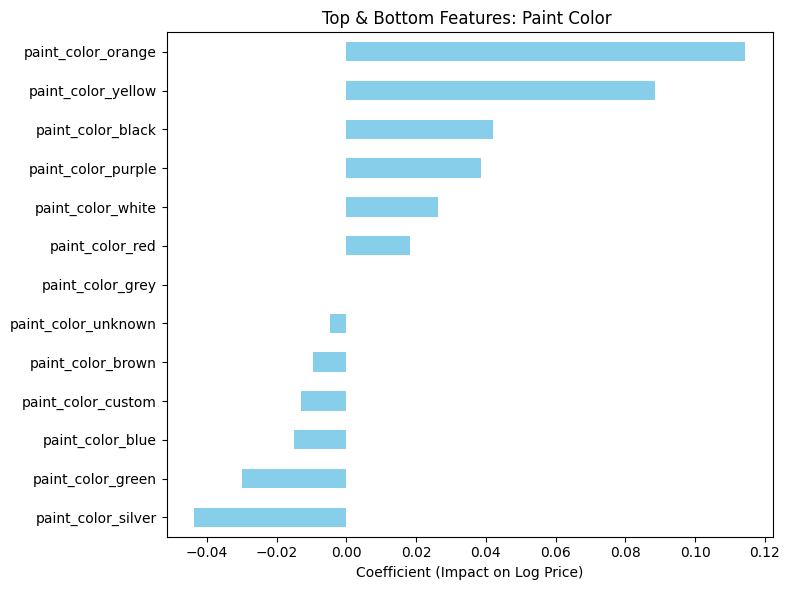

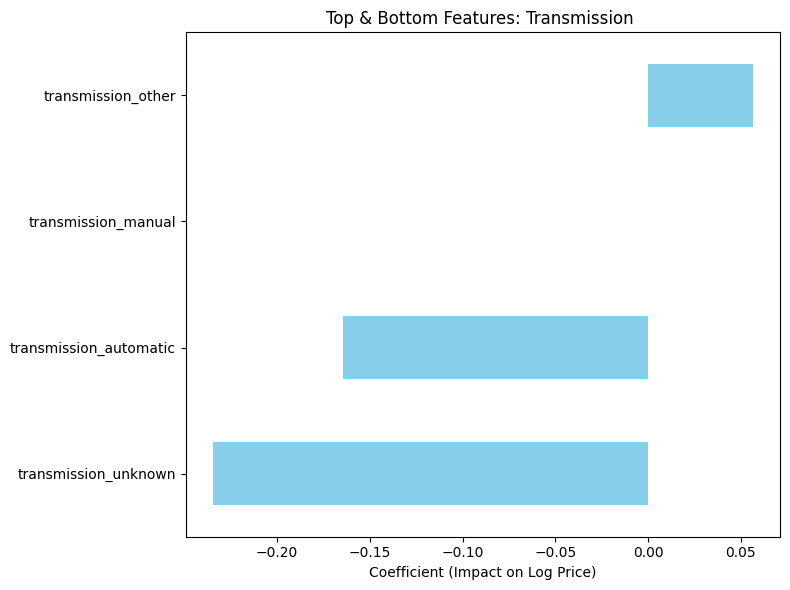

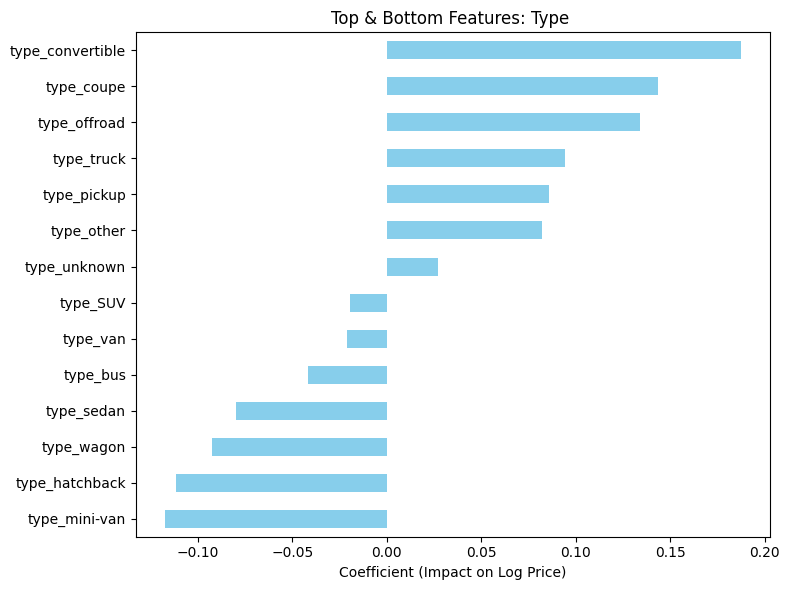

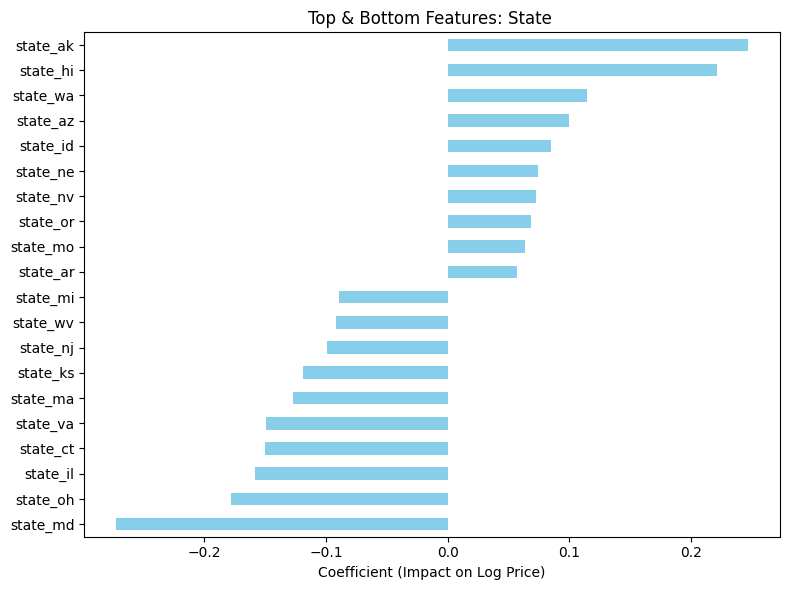

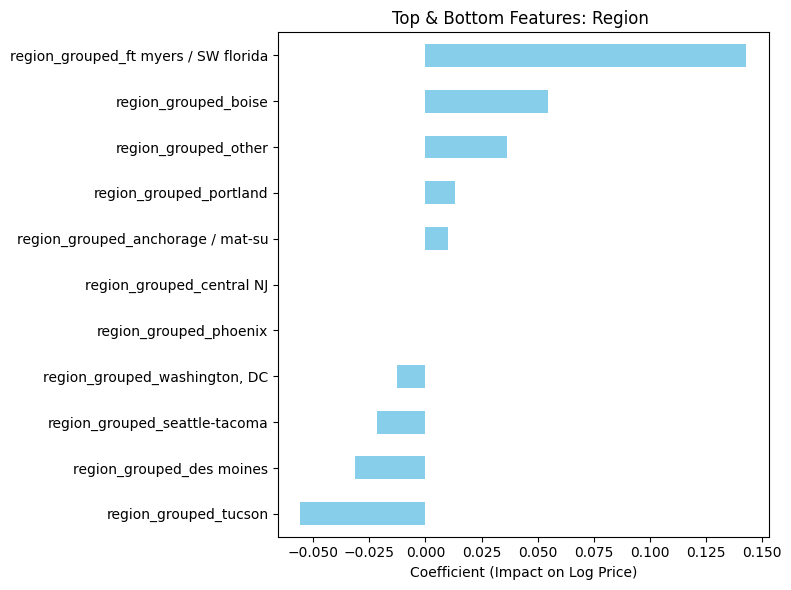

In [62]:
# Retrieve trained pipeline
pipeline_lasso = fitted_pipelines['Lasso Regression']

# Get feature names from fitted preprocessor
feature_names = numerical_cols + list(
    pipeline_linear.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out()
)

# Get coefficients from trained model
lasso_coefs = pd.Series(pipeline_lasso.named_steps['regressor'].coef_, index=feature_names)

# Define feature group prefixes
group_prefixes = [
    'manufacturer_', 'model_', 'condition_', 'cylinders_', 'fuel_',
    'drive_', 'paint_color_', 'transmission_', 'type_', 'state_', 'region_'  # Adjusted from region_grouped_
]

# Plot top 10 and bottom 10 by group without duplicates
features_by_group = {}
for prefix in group_prefixes:
    group_coeffs = lasso_coefs[lasso_coefs.index.str.startswith(prefix)]
    if not group_coeffs.empty:
        sorted_group = group_coeffs.sort_values()
        if len(sorted_group) <= 20:
            top_bottom = sorted_group
        else:
            top_bottom = pd.concat([sorted_group.head(10), sorted_group.tail(10)]).drop_duplicates()
        features_by_group[prefix] = top_bottom

# Plotting
for prefix, series in features_by_group.items():
    plt.figure(figsize=(8, 6))
    series.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top & Bottom Features: {prefix.replace('_', ' ').title()}")
    plt.xlabel("Coefficient (Impact on Log Price)")
    plt.tight_layout()
    plt.show()


### Model Choice
I set out to build a model to help a used car dealership understand what makes certain vehicles more valuable than others. After a significant amount of data cleaning and transformation, I evaluated three regression models: Linear, Ridge, and Lasso.

| Model                | RMSE       | R²         | CV R² (5-fold) |
| -------------------- | ---------- | ---------- | -------------- |
| Linear Regression    | 0.4345     | 0.6687     | 0.4595         |
| **Ridge Regression** | **0.4345** | **0.6687** | **0.4596**     |
| Lasso Regression     | 0.4345     | 0.6687     | 0.4581         |


Although Linear Regression performed almost identically to Ridge in terms of RMSE and R², I ultimately selected Ridge Regression for the final model due to its superior ability to handle high-dimensional, one-hot-encoded feature sets. Ridge also offers better generalization to unseen data, especially in situations with multicollinearity.

### Key predictors of price included:
- Car Age: Strongest factor — average annual depreciation of ~27.7%
- Odometer: Mileage adds ~10.1% annual depreciation
- Drive Type: FWD reduces resale value by ~7.5% compared to AWD/RWD
- Make & Model: Performance and luxury brands (e.g., Ferrari, Corvette) increase value
- Transmission: Manuals sometimes raise value depending on model
- Paint Color: Bold colors (e.g., red, blue) often increase value

### To clean the data:
- Removed extreme outliers like $0 listings and placeholder VINs.
- Dropped redundant year column in favor of car_age
- Grouped rare regions to prevent an explosion of meaningless one-hot-encoded features that introduced noise into the model.

### Changes/Refactor:
#### - Car Age/Year
Initially, I mistakenly kept both year and car_age in the dataset, which skewed results. I later corrected this by focusing only on car_age, which provided more interpretable output and aligned better with business expectations.

#### - Optimization
Originally I just chose the alphas, but I went back and then optimized them and then again changed the Lasso to LassoCV to optimize the optimization so to speak as it took extended processing time to complete and ended up not finding one.

#### - Feature Noise Reduction
I grouped features by type (i.e., model_, manufacturer_, paint_color_, transmission_) and visualized the top and bottom 10 features within each category. This revealed how specific brands, models, or characteristics affect resale value.

#### For example:
- Manual transmissions and unique paint colors were often positively correlated with price.
- Certain makes and models (like Chevy Cobalt or Ford Fiesta) were negatively correlated with resale value.

At this point, we do not believe earlier phases need revision, as the model performs well and provides insights directly aligned with the dealership’s goals.

This model is ready to support pricing recommendations and strategic inventory decisions.



In [67]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.1 MB/s eta 0:00:00


In [80]:
ridge_pipeline = fitted_pipelines['Ridge Regression']

In [81]:
# Get feature names (transformed)
ridge_feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()
ridge_coefficients = ridge_pipeline.named_steps['regressor'].coef_

# Combine and preview
ridge_test_coefs = pd.Series(ridge_coefficients, index=ridge_feature_names)
ridge_test_coefs.sort_values(key=abs, ascending=False).head(20)


,0
cat__manufacturer_ferrari,1.402563
cat__manufacturer_datsun,1.341926
cat__model_cobalt,-0.924997
cat__manufacturer_porsche,0.761893
cat__model_corvette,0.743962
cat__manufacturer_saturn,-0.732150
cat__model_hhr,-0.699068
cat__model_fiesta,-0.697838
cat__model_pt cruiser,-0.648020
cat__model_fj cruiser,0.637956


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Helping You Understand What Makes a Car Worth More
Presented by: Jeremy Foxx | Data Strategy Consultant

## What We Set Out to Do
We know that no two used cars are created equal. Even if two vehicles look similar on paper, one might sell for thousands more, and we wanted to help you understand why.

So, I built a tool, think of it like a smart appraisal engine, that looks at patterns from thousands of real car listings and figures out what actually drives price. The goal? Help you make smarter decisions when buying, pricing, and stocking vehicles.

## How It Works
We trained a model, basically, a smart calculator, by showing it thousands of past car sales with all their details (mileage, model, age, condition, color, etc.) and the final price.

It learned the patterns in the same way you’d learn over years of experience, but it did it in minutes, across way more data than any one person could look at.

**Think of it like having your sharpest appraiser, but one who remembers everything.**

## What We Learned
Here’s what the data taught us about what really drives resale value:

###Biggest Price Boosters:
- **Model & Make:** Certain models (like Corvettes, Ferraris) bring serious heat — up to +39% more in value.
- **Diesel Engines:** On average, +33.8% boost, especially in colder or rural areas where torque and fuel efficiency matter.
- **Location:** Cars sold in Alaska (AK) go for ~30% more, likely due to scarcity or demand up there.
- **Car Age:** Not surprisingly, newer cars = higher prices. But the model also quantifies this: older cars drop ~27.7% per year.
- **4WD / AWD:** Adds value (+9.8%), especially in tough terrain or snow-heavy states.
- **Condition:** Excellent condition consistently adds ~5%.

###Common Price Drags:
- **Automatic Transmissions:** Believe it or not, automatics slightly drop value in some niche markets, often where drivers want performance or control (e.g., sports cars). Still keep in mind though most people prefer automatic so need to keep the customer in mind.

- **SUVs:** Surprisingly, the generic “SUV” tag pulled value down in this particular dataset likely due to oversupply or low-demand models dragging down the average.

###Sample Estimate
We ran a mock appraisal on a 7-year-old, 60,000-mile diesel Acura SUV in Alaska with a clean title.

**Estimated resale price:** $59,463.38

And here’s what contributed most to that number:

| Factor                         | % Impact | \$ Impact        |
| ------------------------------ | -------- | ---------------- |
| Model                          | +39.1%   | +\$23,272        |
| Diesel Engine                  | +33.8%   | +\$20,094        |
| Sold in Alaska                 | +29.7%   | +\$17,642        |
| Age (7 years)                  | +29.1%   | +\$17,307        |
| 4WD                            | +9.8%    | +\$5,832         |
| Automatic Transmission         | −7.6%    | −\$4,497         |
| Others (e.g. color, condition) | Mixed    | ±\$1,000–\$3,000 |


## What We Did Behind the Scenes
Think of our data like a messy garage of a hoarding car collector, useful parts and gems mixed with junk. We cleaned it up:
- Removed junk listings (e.g., $0 prices, fake VINs)
- Grouped obscure regions so the model could focus on patterns, not distractions
- Simplified duplicate info (e.g., got rid of “Year” once we had “Car Age”)

Then we tested different “engines” for the model, think of them like trying different trucks to pull a trailer. We picked the most stable and consistent one, called Ridge Regression, because it’s the least likely to break when we throw it new cars it hasn’t seen before.

##What You Can Do With This
This model gives you two big advantages:
- More confident pricing: Know how much a car is really worth — not just based on gut or KBB — but based on real patterns from real sales.
- Smarter buying: You’ll spot undervalued vehicles or hidden gems before the competition — and avoid overpaying for ones that won't resell well.

I have included the price predictor calculator along with this report. You can then take a look at how the prices of certain models and regions can impact.  In the next section "Strategic Oppurtunities" I have included some of these examples.

##Strategic Opportunities
###Where You Can Win

The data didn’t just tell us what sells for more it showed us where the smart plays are. Below are some patterns that point to profit potential, whether you’re looking to flip quickly or hold for top dollar.


####1. Arbitrage by Region
**Buy in the flatlands, sell in the snow.**

- Vehicles with 4WD or AWD consistently sell for ~10% more in northern or rugged regions (like Alaska, Montana, Colorado).

- If you’re in a lower-demand area (like southern states), sourcing 4WD trucks, SUVs, and diesels locally and shipping them north could create built-in margin.

- Diesel SUVs in particular are undervalued in urban markets but command top dollar in remote and cold-weather markets.

#####**Example Play:**
Buy diesel 4WD SUVs in Texas or Florida → clean them up → resell in Alaska or rural Colorado = potential $5–$8K lift per vehicle.


###2. Fast-Turnover Picks
**These are the “in and out in 30 days” cars.**

- Certain mid-range sedans (like Honda Accord, Toyota Camry) with under 100K miles and excellent condition had high consistency and tight pricing bands — meaning they sell close to list price, fast.

- Clean-title cars with fewer customizations also moved quicker in the data.

- Manual-transmission versions of sporty trims (like Mazda3, Civic Si, older WRX) had small but loyal buyer pools that moved quickly when priced right.

**Tip:** Target vehicles with low price volatility and modest mileage — they don’t deliver huge profits, but they rarely sit.


###3. High-Margin Flips
**Undervalued cars with big upside after reconditioning.**

- Manual transmission sports cars often sell below their real value because most buyers pass, but enthusiasts will pay a premium for the right one.

- “Boring” cars with great bones (i.e., excellent condition Toyota Matrix or Honda Fit) were often underpriced but retained strong resale reliability — meaning you can undercut competitors and still make solid margin.

- Paint color uplift: Unique or premium paint colors (red, blue, white pearl) added subtle, but real value most sellers don’t optimally price. That’s margin waiting to be taken.


###4. Avoid the False Comfort of SUVs
**Don’t assume all SUVs are winners.**

- The “SUV” label alone didn’t guarantee profit it reduced average resale value by ~4% in some segments.

- Why? Oversupply of low-demand SUV trims (i.e., base model crossovers with FWD) drag the average down.

- SUVs still sell, but look beyond the body type. The value comes from the right drivetrain, fuel type, and brand/model combo.

## Quick Win List
| Move                            | Why It Works                                | Estimated Lift  |
|---------------------------------|---------------------------------------------|------------------|
| Source 4WD diesels in warm states | Undervalued locally, premium resale in north | `$5K–$8K`         |
| List sporty manuals w/ proper SEO | Sells fast to niche buyers                 | `+5%–10%`         |
| Highlight unique colors in photos | Increases perceived value & clicks         | `+2%–3%`          |
| Avoid base-model FWD SUVs        | Slow to move, lowest resale ratios         | —                |




Price Predictor:

In [88]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Setup (from trained pipeline) ---
numerical_cols = ['odometer', 'car_age']
categorical_cols = [
    'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
    'drive', 'paint_color', 'transmission', 'type', 'state', 'region_grouped', 'title_status'
]

# Get clean feature names (no cat__/num__)
preprocessor = ridge_pipeline.named_steps['preprocessor']
feature_names_prefixed = preprocessor.get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names_prefixed]

# Get coefficients (clean index)
ridge_coefs = pd.Series(ridge_pipeline.named_steps['regressor'].coef_, index=feature_names)
ridge_coeff_dict = ridge_coefs.to_dict()

# Extract dropdown options
one_hot_encoded_options = {}
for col in categorical_cols:
    prefix = f"{col}_"
    matched = [name for name in feature_names if name.startswith(prefix)]
    values = sorted(set(name.replace(prefix, '') for name in matched))
    one_hot_encoded_options[col] = values

# --- UI Widgets ---
numeric_inputs = {
    'odometer': widgets.IntSlider(description='Odometer (miles)', min=0, max=300000, step=1000, value=60000),
    'car_age': widgets.IntSlider(description='Car Age', min=0, max=30, step=1, value=7)
}

category_inputs = {
    cat: widgets.Dropdown(description=cat.replace('_', ' ').title(), options=vals)
    for cat, vals in one_hot_encoded_options.items()
}

predict_btn = widgets.Button(description='Estimate Price 💰', button_style='success')
out = widgets.Output()

# --- Prediction Logic ---
def estimate_price(event):
    out.clear_output()
    with out:
        # Build input
        user_input = {k: w.value for k, w in numeric_inputs.items()}
        user_input.update({k: w.value for k, w in category_inputs.items()})
        input_df = pd.DataFrame([user_input])

        # Predict total price
        log_price = ridge_pipeline.predict(input_df)[0]
        price_est = np.expm1(log_price)

        # Transform input
        transformed = preprocessor.transform(input_df)
        raw_names = [name.split('__')[-1] for name in preprocessor.get_feature_names_out()]

        # Compute impacts in percent and dollars
        impacts = []
        for name, val in zip(raw_names, transformed[0]):
            if abs(val) > 1e-6:
                coef = ridge_coeff_dict.get(name, 0)
                log_impact = coef * val
                percent = np.expm1(log_impact) * 100
                dollar = np.expm1(log_impact) * price_est

                # Clean label
                if '_' in name:
                    base, value = name.rsplit('_', 1)
                    label = f"{base.replace('_', ' ').title()}: {value.replace('_', ' ').title()}"
                else:
                    label = name.replace('_', ' ').title()

                # Filter out <1% change
                if abs(percent) >= 1:
                    sign = "+" if percent > 0 else "-"
                    impacts.append((label, f"{sign}{abs(percent):.1f}%", f"{sign}${abs(dollar):,.0f}"))

        # Sort by biggest %
        impacts.sort(key=lambda x: -abs(float(x[1].replace('%',''))))

        # Output
        print(f"\n💵 Estimated resale price: ${price_est:,.2f}\n")
        print("🔍 Feature Impact Breakdown (only >±1% shown):")
        for label, pct, dollar in impacts:
            print(f"{label}: {pct}  ({dollar})")

# --- Display UI ---
predict_btn.on_click(estimate_price)
ui = list(numeric_inputs.values()) + list(category_inputs.values()) + [predict_btn, out]
display(widgets.VBox(ui))
